## Bayesian Spatiotemporal Binomial GFL example in 3D grid

In [1]:
using Pkg; Pkg.activate(".");
using Statistics
using StatsFuns
using LinearAlgebra
using Distributions
using Colors
using ProgressMeter
using Base.Threads
using AdaptiveRejectionSampler
using Plots; default(fmt = :png)

 Activating environment at `C:\Users\mauri\Github\BayesianGFL\Project.toml`


### Gibbs sampler code

Below is all the code for the gibbs sampler. It uses an Adaptive Rejection Sampler which samples very efficiently from any scalar distribution with convex loglikelihoods. The code uses asynchronous parallel updates.

See the code here for the sampler: https://github.com/mauriciogtec/AdaptiveRejectionSampling.jl

In [2]:
function binomial_gibbs_step(
    s::Float64,  # successes
    a::Float64,  # attempts
    nbr_values::Vector{Float64} = [0.0],
    ;
    λ_tv1::Vector{Float64} = zeros(length(s)),
    λ_tv2::Vector{Float64} = zeros(length(s)),
    λ_lasso::Float64 = 0.0,
    λ_ridge::Float64 = 0.0,
)::Float64 
    # add a small constant for numerical stability
    ϵ = 1e-8
    a = a + 2ϵ
    s = s + ϵ
    
    # define target loglikelihood
    target_logll(θ::Float64) = begin
        logll = if θ >= 0
            logll = - a * log(1.0 + exp(-θ)) - (a - s) * θ
        else
            logll = s * θ - a * log(1.0 + exp(θ))
        end
        tv1 = dot(abs.(θ .- nbr_values), λ_tv1)
        tv2 = dot((θ .- nbr_values).^2, λ_tv2)
        lasso_reg = λ_lasso * abs(θ)
        ridge_reg = λ_ridge * θ^2
        logll - tv1 - tv2 - lasso_reg - ridge_reg
    end
    
    # construct the rejection sampler
    support = (-Inf, Inf)
    
    # efficiency of the sample increase with good envelope points
    # for the rejection sampler, must have postive and negative slope
    envelope_init = (
        min(logit(s / a),  minimum(nbr_values)) - 1e-6,
        max(logit(s / a), maximum(nbr_values)) + 1e-6
    )
    sampler = RejectionSampler(
        target_logll, support, envelope_init, max_segments=10, from_log=true
    )
    
    # return one sample
    run_sampler!(sampler, 1)[1]
end 


function binomial_gibbs_sweep(
    θ::Vector{Float64},  # current
    s::Vector{Float64},  # successes
    a::Vector{Float64},  # attempts
    nbrs::Vector{Vector{Int}} # neighbors
    ;
    λ_tv1::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_tv2::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_lasso::Vector{Float64} = zeros(length(s)),
    λ_ridge::Vector{Float64} = zeros(length(s)),
)
    T = length(θ)
    θnew = zeros(Float64, T)
    
    # async updates using multiple threads
    @inbounds @threads for t in 1:T
        nbr_values = [θ[i] for i in nbrs[t]]
        θnew[t] = binomial_gibbs_step(
            s[t],
            a[t],
            nbr_values,
            λ_tv1=λ_tv1[t],
            λ_tv2=λ_tv2[t],
            λ_lasso=λ_lasso[t],
            λ_ridge=λ_ridge[t]
        )
    end
    return θnew
end


function binomial_bayesian_gfl(
    s::Vector{Float64},  # successes
    a::Vector{Float64},  # attempts
    nbrs::Vector{Vector{Int}},
    n::Int  # chain iterations (full sweeps),
    ;
    λ_tv1::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_tv2::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_lasso::Vector{Float64} = zeros(length(s)),
    λ_ridge::Vector{Float64} = zeros(length(s)),
    θ₀::Vector{Float64} = zeros(length(s))  # initial values
)
    T = length(s)
    θ = zeros(Float64, T, n + 1)
    θ[:, 1] = θ₀

    # stone each gibbs sweep in matrix
    @showprogress for i in 1:n
        θ[:, i + 1] = binomial_gibbs_sweep(
            θ[:, i], s, a, nbrs; λ_tv1=λ_tv1, λ_tv2=λ_tv2, λ_lasso=λ_lasso, λ_ridge=λ_ridge
        )
    end
    return θ
end

binomial_bayesian_gfl (generic function with 1 method)

### Data

The code below simulates from a Binomial distribution spatially arranged probablities (0.7 or 0.3) and with a random number of observations (1 or 5) to inject noise.

In [3]:
nr = 61
nc = 61
nk = 30

grid = zeros(nr, nc, nk)
s = zeros(nr, nc, nk)
a = zeros(nr, nc, nk)

for k in 1:nk
    for j in 1:nc
        for i in 1:nr
            b = Float64((i - (nr / 2)) * (j - (nc / 2)) * (k - nk / 2) ≥ 0)
            δk = (0.5 / nk) * (k ÷ (nk ÷ 5))
            grid[i, j, k] = 0.7 * b + 0.3 * (1 - b)
            a[i, j, k] = rand([1, 5.])
            s[i, j, k] = rand(Binomial(a[i, j, k], grid[i, j, k]))
        end
    end
end



# build graph
nbrs = Vector{Int}[]
index_map = reshape(1:(nr * nc * nk), (nr, nc, nk));
λ_tv1 = Vector{Float64}[]
λ_tv2 = Vector{Float64}[]
for k in 1:nk
    for j in 1:nc
        for i in 1:nr
            nbrs_ = Int[]
            (i > 1) && push!(nbrs_, index_map[i - 1, j, k])
            (i < nr) && push!(nbrs_, index_map[i + 1, j, k])
            (j > 1) && push!(nbrs_, index_map[i, j - 1, k])
            (j < nc) && push!(nbrs_, index_map[i, j + 1, k])
            (k > 1) && push!(nbrs_, index_map[i, j, k - 1])
            (k < nk) && push!(nbrs_, index_map[i, j, k + 1])
            push!(nbrs, nbrs_)
            push!(λ_tv1, 5.0 * ones(length(nbrs_)))
            push!(λ_tv2, 0.0 * ones(length(nbrs_)))
        end
    end
end
s_vec = vec(s);
a_vec = vec(a);

In [4]:
print("Graph with $(length(vec(grid))) nodes and $(sum([length(x) for x in nbrs]) ÷ 2) edges")

Graph with 111630 nodes and 327509 edges

┌ Info: Saved animation to 
│   fn = C:\Users\mauri\Github\BayesianGFL\grid.gif
└ @ Plots C:\Users\mauri\.julia\packages\Plots\cc8wh\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\mauri\\Github\\BayesianGFL\\grid.gif")
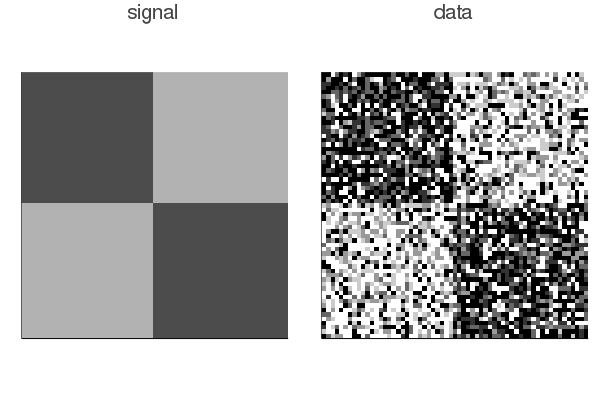

In [5]:
data = ((s .+ 1e-6) ./ (a .+ 2e-6))

anim = @animate for k in 1:nk
    p1 = plot(Gray.(grid[:, :, k]), title="signal")
    p2 = plot(Gray.(data[:, :, k]), title="data")
    plot(p1, p2, axis=nothing)
end
gif(anim, "grid.gif", layout=(1, 2), figsize=(500, 250), fps = 15)

### Results

The chain mixing looks pretty good. It takes about 2h to run in personal computer. Although it seems like mixing is pretty good from start. It is somewhat easy problem though.

In [6]:
N = 10_000
@time chain = binomial_bayesian_gfl(s_vec, a_vec, nbrs, N, λ_tv1=λ_tv1, λ_tv2=λ_tv2);

Progress: 100%|█████████████████████████████████████████| Time: 1:56:48


7010.062993 seconds (249.91 G allocations: 8.290 TiB, 45.23% gc time)


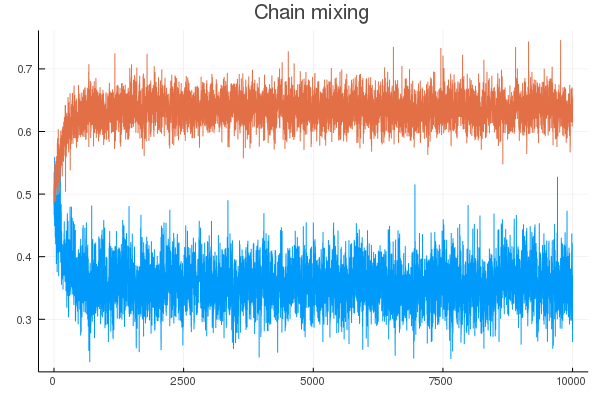

In [7]:
plot(logistic.(chain[[1, 3000], :]'), lab="", title="Chain mixing")

┌ Info: Saved animation to 
│   fn = C:\Users\mauri\Github\BayesianGFL\solution.gif
└ @ Plots C:\Users\mauri\.julia\packages\Plots\cc8wh\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\mauri\\Github\\BayesianGFL\\solution.gif")
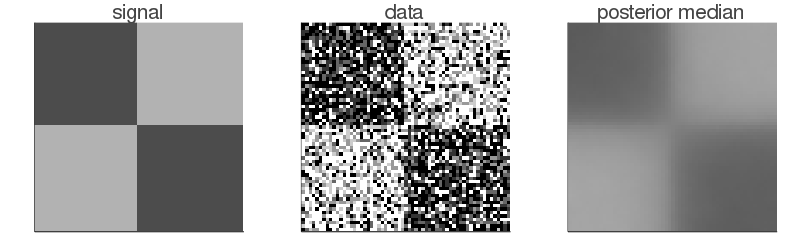

In [10]:
burnin = N - 5_000
m = vec(median(chain[:, burnin + 1:end], dims=2));
m = logistic.(reshape(m, (nr, nc, nk)));

anim = @animate for k in 1:nk
    p1 = plot(Gray.(grid[:, :, k]), title="signal")
    p2 = plot(Gray.(phat[:, :, k]), title="data")
    p3 = plot(Gray.(m[:, :, k]), title="posterior median")
    plot(p1, p2, p3, layout=(1, 3), size=(800, 250), axis=nothing)
end
gif(anim, "solution.gif", fps = 15)